# Start Up

In [1]:
# Import libraries
from arcgis.learn import prepare_data, FeatureClassifier
from PIL import Image
import shutil
import os
import os.path
import arcpy
from arcpy.ia import *
from arcgis import gis
from arcgis.gis import GIS
from arcgis.learn import Model
from arcgis.learn import detect_objects
from arcgis.learn import classify_objects
import zipfile
import sys
import getpass
import tensorflow as tf
import numpy
import xml.etree.ElementTree as ET
import sklearn
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from sklearn.model_selection import KFold
import os
import statistics  
import arcgis
import math
arcpy.CheckOutExtension("ImageAnalyst")
arcpy.env.overwriteOutput = True

### Prepare data

In [2]:
b_path = r"C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2"

In [3]:
# Create file structure
files = ["Training", "Testing", "Generalization"]
for f in files:
    try:
       shutil.rmtree(b_path + f)
    except:
        pass
for f in files:
    try:
       os.mkdir(b_path + f)
    except:
        pass

In [4]:
#Function to find ground truth data
def parseXML(xmlfile): 
  
    # create element tree object 
    tree = ET.parse(xmlfile) 
  
    # get root element 
    root = tree.getroot() 
  
    for it in root.findall('./object/name'):
        if it.text == '0':
            return ["No Damage", "0"]
        elif it.text == '1':
            return ["Damage", "1"]
        else:
            return ["ERROR", "E"]

In [6]:
# Selecting Training, Validation, and Testing data
#load building footprint feature class
in_feature_class = os.path.join(b_path, "Building_Damage_Assessment.gdb", "Building_Footprints")
#create a copy of the feature class
fc = in_feature_class + "_copy"
arcpy.Copy_management(in_feature_class, in_feature_class + "_copy")

arcpy.AddField_management(fc, "group", "TEXT", 10, "", "", "group", 
                          "NULLABLE", "REQUIRED")

#create a list of value from classname field
rows = [row for row in arcpy.da.SearchCursor(fc,'Classname')]

#Separate features into Damage and No Damage groups
damage = []
no_damage = []
fields = ['OBJECTID','Classname']
with arcpy.da.SearchCursor(fc, fields) as cursor:
    for row in cursor:
        if row[1] == 'Damage':
            damage.append(row)
        elif row[1] == 'No Damage':
            no_damage.append(row)

#split each group into training/testing
tr = .75
te = .25

# Damage
d_train,d_test = train_test_split(damage, test_size=te, train_size=tr, random_state=72)

# No Damage
nd_train,nd_test = train_test_split(no_damage, test_size=te, train_size=tr, random_state=72)

#Tag each feature with either 'Training' or 'Testing'
fields = ['OBJECTID','group_']
with arcpy.da.UpdateCursor(fc, fields) as cursor:
    for row in cursor:
        for r in d_train:
            if row[0] == r[0]:
                row[1] = 'Training'
        for r in nd_train:
            if row[0] == r[0]:
                row[1] = 'Training'
        for r in d_test:
            if row[0] == r[0]:
                row[1] = 'Testing'
        for r in nd_test:
            if row[0] == r[0]:
                row[1] = 'Testing'
        cursor.updateRow(row)

print('Actual Sample Count:')
print('- Training Samples:')
print('-- Damage: ', len(d_train))
print('-- No Damage: ', len(nd_train))
print('- Testing Samples:')
print('-- Damage: ', len(d_test))
print('-- No Damage: ', len(nd_test))

Actual Sample Count:
- Training Samples:
-- Damage:  195
-- No Damage:  150
- Testing Samples:
-- Damage:  66
-- No Damage:  50


In [5]:
#5 fold validation

import os
import arcpy


# Set the path to your feature class
in_feature_class = os.path.join(b_path, "Building_Damage_Assessment.gdb", "Building_Footprints")

# Create a copy of the feature class to work with
fc = in_feature_class + "_copy"
arcpy.Copy_management(in_feature_class, fc)

# Add a new field to store fold assignments
arcpy.AddField_management(fc, "Fold", "SHORT", field_alias="Fold")

# Extract OBJECTID and Classname for each feature
fields = ['OBJECTID', 'Classname']
data = [(row[0], row[1]) for row in arcpy.da.SearchCursor(fc, fields)]

# Separate features into Damage and No Damage groups
damage = [item for item in data if item[1] == 'Damage']
no_damage = [item for item in data if item[1] == 'No Damage']

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Function to assign fold numbers
def assign_folds(group):
    object_ids = [item[0] for item in group]
    folds = {}
    for fold_number, (_, test_index) in enumerate(kf.split(object_ids), start=1):
        for idx in test_index:
            folds[object_ids[idx]] = fold_number
    return folds

# Assign folds to each group
damage_folds = assign_folds(damage)
no_damage_folds = assign_folds(no_damage)

# Combine fold assignments
fold_assignments = {**damage_folds, **no_damage_folds}

# Update the 'Fold' field in the feature class
with arcpy.da.UpdateCursor(fc, ['OBJECTID', 'Fold']) as cursor:
    for row in cursor:
        obj_id = row[0]
        if obj_id in fold_assignments:
            row[1] = fold_assignments[obj_id]
            cursor.updateRow(row)

print("Fold assignments completed successfully.")


ExecuteError: ERROR 000464: Cannot get exclusive schema lock.  Either being edited or in use by another application or service.
Failed to execute (Copy).


In [7]:
# Splitting shapefiles based on group_(Training and Testing)
target_workspace = os.path.join(b_path, "Building_Damage_Assessment.gdb")
for f in ['Testing', 'Training']:
    try:
        arcpy.Delete_management(target_workspace + '\\' + f)
    except:
        pass


fields = ['group_']
arcpy.SplitByAttributes_analysis(fc, target_workspace, fields)

<Result 'C:\\Users\\iaadeniran\\Documents\\PostDoc\\Updated_Model\\Coding\\BDA2\\Building_Damage_Assessment.gdb'>

### Transformation Training

##### Extract Training Data + Static augumentation using ArcGis library

In [8]:
#create folder to save training data
td = os.path.join(b_path, "Training")

if os.path.exists(td):
    shutil.rmtree(td)
os.mkdir(td)

#td = r"C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2"

#Import input imagery for the study area
in_raster = os.path.join(b_path, "2010_01_15_proj.gdb", "c2010_01_15_mosaic")

out_folder = td

# load traing features 
in_class_data = os.path.join(b_path, "Building_Damage_Assessment.gdb", "Training")

#set Chip and Tile Configuration
image_chip_format = 'TIFF'
tile_size = 128
stride = tile_size/2
metadata_format = 'Labeled_Tiles'
reference_system = 'MAP_SPACE'
blacken_around_feature = 'BLACKEN_AROUND_FEATURE'
crop_mode = 'FIXED_SIZE'
rotation_angle = 72.0

#call the ExportTrainingDataForDeepLearning function 
chips = ExportTrainingDataForDeepLearning(in_raster = in_raster, out_folder = out_folder, in_class_data = in_class_data,
                                         image_chip_format = image_chip_format, tile_size_x = tile_size, 
                                         tile_size_y = tile_size, stride_x = stride, stride_y = stride,
                                         metadata_format = metadata_format, reference_system = reference_system,
                                         blacken_around_feature = blacken_around_feature, 
                                         crop_mode = crop_mode, rotation_angle = rotation_angle) 
                                            

##### Dynamic augumentation using fastai

<class 'fastai.vision.data.ImageDataBunch'>


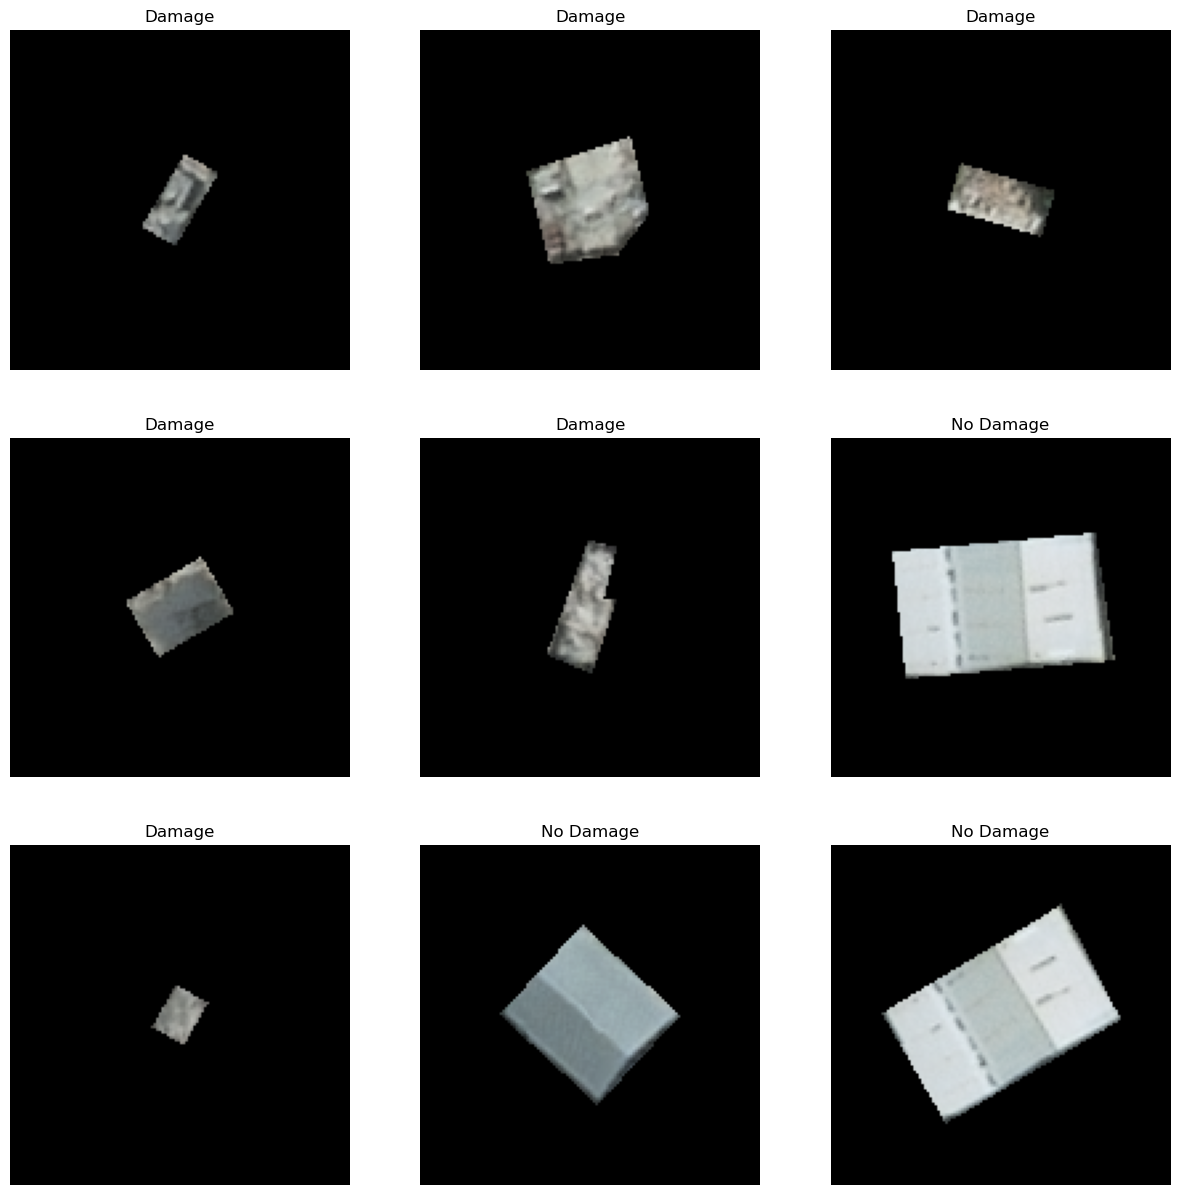

In [9]:
from fastai.vision.transform import zoom_crop
from fastai.vision.transform import get_transforms


tfm = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1.0, 
                     max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=None)


#Prepare Image Data
im_data = prepare_data(
    td, 
    {0:'No Damage', 1:'Damage'}, 
    seed = 42, chip_size = 128, 
    val_split_pct=0.2, 
    transforms=tfm)

#Visualize the Data
print(type(im_data))
im_data.show_batch()

##### Model training

In [10]:
# Load pretraind model path
pretrained_path = os.path.join(b_path, "models", "DA_DamagedBuildings", "DA_DamagedBuildings.emd")

# Initiate model
model = FeatureClassifier(
    im_data, 
    backbone = 'resnet152', 
    pretrained_path = pretrained_path
)
print(type(model))



<class 'arcgis.learn.models._classifier.FeatureClassifier'>


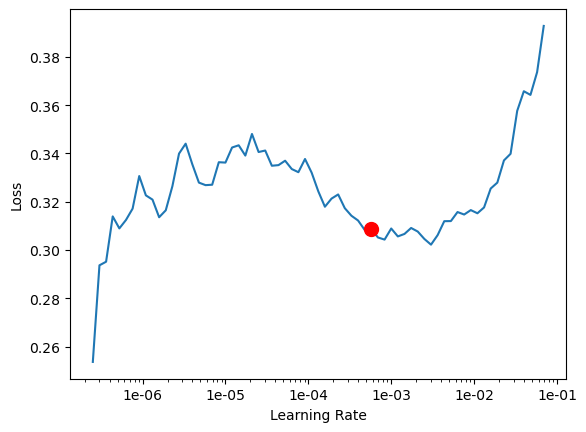

0.0005754399373371565


In [11]:
#Plot the learning rate vs. loss curve to choos suitable lr
learn = model.lr_find()
print(learn)

In [12]:
# Train model
model.fit(epochs=50, lr = learn, early_stopping=True) #, early_stopping=True

epoch,train_loss,valid_loss,accuracy,time
0,0.325062,0.298086,0.895652,00:04
1,0.328181,0.256590,0.898551,00:03
2,0.306349,0.215090,0.915942,00:03
3,0.283799,0.180167,0.939130,00:03
4,0.267252,0.177207,0.930435,00:03
5,0.235067,0.165115,0.933333,00:03
6,0.221968,0.210793,0.918841,00:03
7,0.192694,0.187321,0.944928,00:03
8,0.174354,0.147228,0.942029,00:03
9,0.157306,0.130927,0.939130,00:03


Epoch 15: early stopping


##### Statistics - Validtion

In [13]:
# Save Model
model.save(os.path.join(b_path, "FINAL_RESULTS", "TestK"))

Computing model metrics...


WindowsPath('C:/Users/iaadeniran/Documents/PostDoc/Updated_Model/Coding/BDA2/FINAL_RESULTS/TestK')

69.0


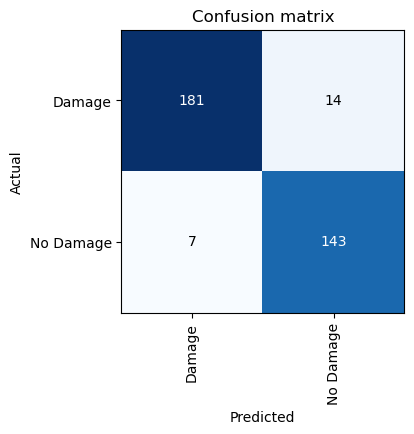

In [14]:
# Plot Confusion Matrix - Validation
print((len(nd_train)+len(d_train))*.2)
matrix = model.plot_confusion_matrix()

In [15]:
# Input validation results
d_d = int(input("Actual = Damage, Predicted = Damage   : "))
d_nd = int(input("Actual = Damage, Predicted = No Damage: "))
nd_d = int(input("Actual = No Damage, Predicted = Damage: "))
nd_nd = int(input("Actual = No Damage, Predicted = No Damage : "))

Actual = Damage, Predicted = Damage   :  181
Actual = Damage, Predicted = No Damage:  14
Actual = No Damage, Predicted = Damage:  7
Actual = No Damage, Predicted = No Damage :  143


In [16]:
# Validation Results
TP = d_d
TN = nd_nd
FP = nd_d
FN = d_nd

# Accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)

# Recall (Damage)
recall_d = TP/(TP+FN)

# Recall (No Damage)
recall_nd = TN/(TN+FP)

# Cohen's Kappa
po = (TP+TN)/(TP+FN+TN+FP)
pyes = ((TP+FN)/(TP+FN+TN+FP))*((TP+FP)/(TP+FN+TN+FP))
pno = ((FP+TN)/(TP+FN+TN+FP))*((FN+TN)/(TP+FN+TN+FP))
pe = pyes+pno
cohens = (po-pe)/(1-pe)

# Matthews Correlation Coefficient
mcc = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Precision
precision_d = TP/(TP+FP)
precision_nd = TN/(TN+FN)

# F1 Score
f1_d = 2*((precision_d*recall_d)/(precision_d+recall_d))
f1_nd = 2*((precision_nd*recall_nd)/(precision_nd+recall_nd))


print(f"Accuracy: {accuracy:.4f}")
print(f"Recall_d: {recall_d:.4f}")
print(f"Recall_nd: {recall_nd:.4f}")
print(f"Cohen's Kappa_d: {cohens:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Precision_d: {precision_d:.4f}")
print(f"Precision_nd: {precision_nd:.4f}")
print(f"F1 Score_d: {f1_d:.4f}")
print(f"F1 Score_nd: {f1_nd:.4f}")

Accuracy: 0.9391
Recall_d: 0.9282
Recall_nd: 0.9533
Cohen's Kappa_d: 0.8768
Matthews Correlation Coefficient: 0.8776
Precision_d: 0.9628
Precision_nd: 0.9108
F1 Score_d: 0.9452
F1 Score_nd: 0.9316


#### Statistics - Training

In [17]:
path = os.path.join(b_path, "Training", "labels")
gt = []
for i in os.listdir(path):
    if '.xml' in i:
        gt.append(parseXML(path + "\\" + i)[0])

In [18]:
# Make predictions with confidences
path = images_path = os.path.join(b_path, "Training", "images")
preds = []
confs = []
for i in os.listdir(path):
    if '.tif' in i:
        #Find Ground Truth too
        pred_conf = model.predict(os.path.join(path, i))
        pred = str(pred_conf[0])
        preds.append(pred)
        conf = tf.make_tensor_proto(pred_conf[2][pred_conf[1]])
        conf = tf.make_ndarray(conf)
        confs.append(conf)

[[941  34]
 [ 14 736]]


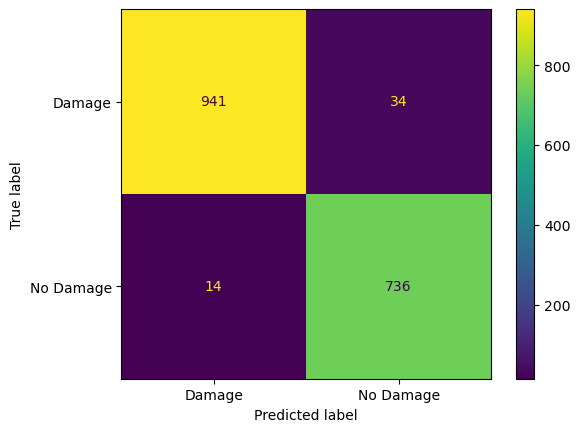

In [19]:
# Training Confusion Matrix - Initial(including data from validation matrix)
matrix = sklearn.metrics.confusion_matrix(gt, preds, labels=['Damage','No Damage'])
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=['Damage','No Damage'])
print(matrix)
disp.plot()

[[760  20]
 [  7 593]]


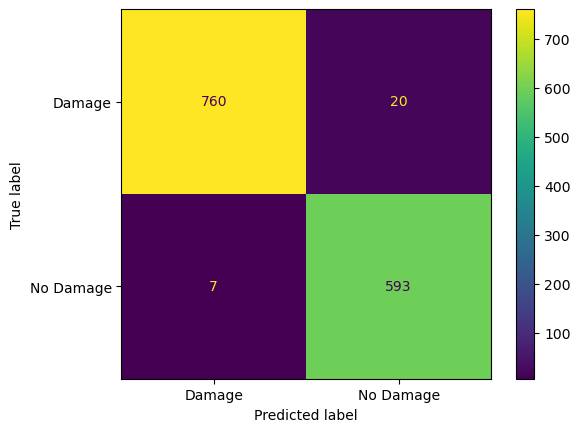

In [20]:
# Training Confusion Matrix - Final(removing data from validation matrix)
matrix[0][0] = matrix[0][0] - d_d
matrix[0][1] = matrix[0][1] - d_nd
matrix[1][0] = matrix[1][0] - nd_d
matrix[1][1] = matrix[1][1] - nd_nd
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=['Damage','No Damage'])
print(matrix)
disp.plot()

In [21]:
# Training Results
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[1][0]
FN = matrix[0][1]

# Accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)

# Recall (Damage)
recall_d = TP/(TP+FN)

# Recall (No Damage)
recall_nd = TN/(TN+FP)

# Cohen's Kappa
po = (TP+TN)/(TP+FN+TN+FP)
pyes = ((TP+FN)/(TP+FN+TN+FP))*((TP+FP)/(TP+FN+TN+FP))
pno = ((FP+TN)/(TP+FN+TN+FP))*((FN+TN)/(TP+FN+TN+FP))
pe = pyes+pno
cohens = (po-pe)/(1-pe)

# Matthews Correlation Coefficient
mcc = ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Precision
precision_d = TP/(TP+FP)
precision_nd = TN/(TN+FN)

# F1 Score
f1_d = 2*((precision_d*recall_d)/(precision_d+recall_d))
f1_nd = 2*((precision_nd*recall_nd)/(precision_nd+recall_nd))

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall_d: {recall_d:.4f}")
print(f"Recall_nd: {recall_nd:.4f}")
print(f"Cohen's Kappa_d: {cohens:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Precision_d: {precision_d:.4f}")
print(f"Precision_nd: {precision_nd:.4f}")
print(f"F1 Score_d: {f1_d:.4f}")
print(f"F1 Score_nd: {f1_nd:.4f}")

Accuracy: 0.9804
Recall_d: 0.9744
Recall_nd: 0.9883
Cohen's Kappa_d: 0.9603
Matthews Correlation Coefficient: 0.9605
Precision_d: 0.9909
Precision_nd: 0.9674
F1 Score_d: 0.9825
F1 Score_nd: 0.9777


#### Calculate and Predict New Training Fields without static augumentation

In [22]:
# Insert new image chip extraction if you rotate transform finetune images
# Extract Training Data

td = os.path.join(b_path, "Training")

if os.path.exists(td):
    shutil.rmtree(td)
os.mkdir(td)

in_raster = os.path.join(b_path, "2010_01_15_proj.gdb", "c2010_01_15_mosaic")
out_folder = td

# Select Data
in_class_data = os.path.join(b_path, "Building_Damage_Assessment.gdb", "Training")
image_chip_format = 'TIFF'
tile_size = 128
stride = tile_size/2
metadata_format = 'Labeled_Tiles'
reference_system = 'MAP_SPACE'
blacken_around_feature = 'BLACKEN_AROUND_FEATURE'
crop_mode = 'FIXED_SIZE'
chips = ExportTrainingDataForDeepLearning(in_raster = in_raster, out_folder = out_folder, in_class_data = in_class_data,
                                         image_chip_format = image_chip_format, tile_size_x = tile_size, 
                                         tile_size_y = tile_size, stride_x = stride, stride_y = stride,
                                         metadata_format = metadata_format, reference_system = reference_system,
                                         blacken_around_feature = blacken_around_feature, 
                                         crop_mode = crop_mode)

In [23]:
path = os.path.join(b_path, "Training", "labels")
gt = []
for i in os.listdir(path):
    if '.xml' in i:
        gt.append(parseXML(path + "\\" + i)[0])

In [24]:
# Make predictions with confidences
path = os.path.join(b_path, "Training", "images")
preds = []
confs = []
for i in os.listdir(path):
    if '.tif' in i:
        #Find Ground Truth too
        pred_conf = model.predict(os.path.join(path, i))
        pred = str(pred_conf[0])
        preds.append(pred)
        conf = tf.make_tensor_proto(pred_conf[2][pred_conf[1]])
        conf = tf.make_ndarray(conf)
        confs.append(conf)


[[190   5]
 [  4 146]]


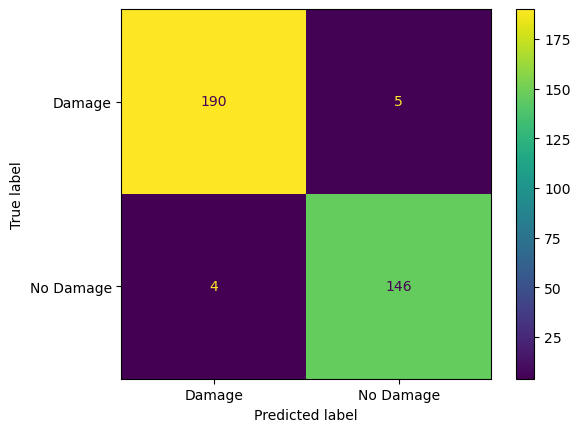

In [25]:
# Training Confusion Matrix - Final
matrix = sklearn.metrics.confusion_matrix(gt, preds, labels = ['Damage','No Damage'])
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels = ['Damage','No Damage'])
print(matrix)
disp.plot()

194 151 195 150
336 9
190 4 146 5
-----
Accuracy: 0.9739
Recall (class 0): 0.9744
Recall (class 1): 0.9733
Cohen's Kappa: 0.9470
Matthews Correlation Coefficient: 0.9470
Precision (class 0): 0.9794
Precision (class 1): 0.9669
F1 Score (class 0): 0.9769
F1 Score (class 1): 0.9701
[[190   5]
 [  4 146]]


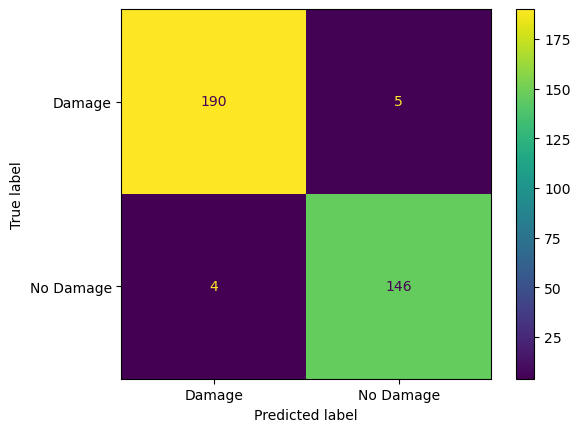

In [26]:
#Count Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(gt, preds, labels = ['Damage','No Damage'])
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=['Damage','No Damage'])
disp.plot()

#Predicted Correctly, Wrongly ------------- PREDICTED Wrong   or     PREDICTED Correct
total = len(preds)
d_pred = preds.count('Damage')
nd_pred = preds.count('No Damage')

d_gt = gt.count('Damage')
nd_gt = gt.count('No Damage')

correct = matrix[0][0]+matrix[1][1]
wrong = matrix[0][1]+matrix[1][0]

d_correct = matrix[0][0]
d_wrong = matrix[1][0]
nd_correct = matrix[1][1]
nd_wrong = matrix[0][1]

#Accuracy
accuracy = sklearn.metrics.accuracy_score(gt, preds)

#Recall (Sensitivity)
recall = sklearn.metrics.recall_score(gt, preds, average=None)

#Cohen's Kappa
cohen = sklearn.metrics.cohen_kappa_score(gt, preds)

#Matthews
matthews = sklearn.metrics.matthews_corrcoef(gt, preds)

#Precision
precision = sklearn.metrics.precision_score(gt, preds, average=None)

#F1 Score
f1 = sklearn.metrics.f1_score(gt, preds, average=None)

print(d_pred, nd_pred, d_gt, nd_gt)
print(correct, wrong)
print(d_correct, d_wrong, nd_correct, nd_wrong)
print("-----")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall (class 0): {recall[0]:.4f}")
print(f"Recall (class 1): {recall[1]:.4f}")
print(f"Cohen's Kappa: {cohen:.4f}")
print(f"Matthews Correlation Coefficient: {matthews:.4f}")
print(f"Precision (class 0): {precision[0]:.4f}")
print(f"Precision (class 1): {precision[1]:.4f}")
print(f"F1 Score (class 0): {f1[0]:.4f}")
print(f"F1 Score (class 1): {f1[1]:.4f}")



print(matrix)

# Generalization

In [32]:
# Extract Generalization Data
td = r"C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2\Generalization"


in_raster = r'C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2\2010_01_15_proj.gdb\c2010_01_15_mosaic'
out_folder = td

# Select Data
in_class_data = r'C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2\Building_Damage_Assessment.gdb\Generalization'
image_chip_format = 'TIFF'
tile_size = 128
stride = tile_size/2
metadata_format = 'Labeled_Tiles'
reference_system = 'MAP_SPACE'
blacken_around_feature = 'BLACKEN_AROUND_FEATURE'
crop_mode = 'FIXED_SIZE'
chips = ExportTrainingDataForDeepLearning(in_raster = in_raster, out_folder = out_folder, in_class_data = in_class_data,
                                         image_chip_format = image_chip_format, tile_size_x = tile_size, 
                                         tile_size_y = tile_size, stride_x = stride, stride_y = stride,
                                         metadata_format = metadata_format, reference_system = reference_system,
                                         blacken_around_feature = blacken_around_feature, 
                                         crop_mode = crop_mode)


In [33]:
path = r"C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2\Generalization\labels"
gt = []
for i in os.listdir(path):
    if '.xml' in i:
        gt.append(parseXML(path + "\\" + i)[0])

In [34]:
# Make predictions with confidences
path = r"C:\Users\iaadeniran\Documents\PostDoc\Updated_Model\Coding\BDA2\Generalization\images\\"
preds = []
confs = []
for i in os.listdir(path):
    if '.tif' in i:
        #Find Ground Truth too
        pred_conf = model.predict(path + i)
        pred = str(pred_conf[0])
        preds.append(pred)
        conf = tf.make_tensor_proto(pred_conf[2][pred_conf[1]])
        conf = tf.make_ndarray(conf)
        confs.append(conf)

95 94 70 119
134 55
55 40 79 15
0.708994708994709
0.7857142857142857
0.6638655462184874
0.4187866927592955
0.43421376999145744
0.5789473684210527
0.8404255319148937
0.6666666666666667
0.7417840375586855
[[55 15]
 [40 79]]


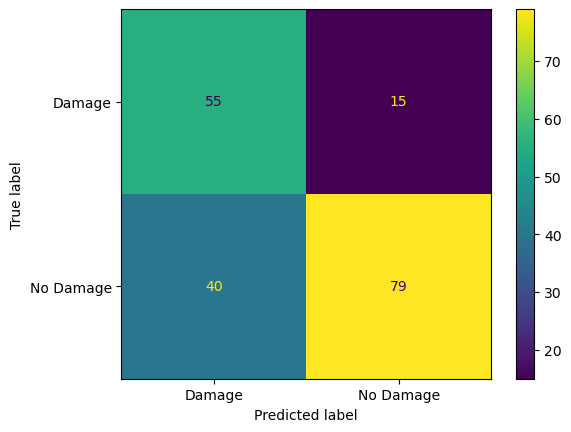

In [35]:
#Count Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(gt, preds, labels = ['Damage','No Damage'])
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=['Damage','No Damage'])
disp.plot()

#Predicted Correctly, Wrongly ------------- PREDICTED Wrong   or     PREDICTED Correct
total = len(preds)
d_pred = preds.count('Damage')
nd_pred = preds.count('No Damage')

d_gt = gt.count('Damage')
nd_gt = gt.count('No Damage')

correct = matrix[0][0]+matrix[1][1]
wrong = matrix[0][1]+matrix[1][0]

d_correct = matrix[0][0]
d_wrong = matrix[1][0]
nd_correct = matrix[1][1]
nd_wrong = matrix[0][1]

#Accuracy
accuracy = sklearn.metrics.accuracy_score(gt, preds)

#Recall (Sensitivity)
recall = sklearn.metrics.recall_score(gt, preds, average=None)

#Cohen's Kappa
cohen = sklearn.metrics.cohen_kappa_score(gt, preds)

#Matthews
matthews = sklearn.metrics.matthews_corrcoef(gt, preds)

#Precision
precision = sklearn.metrics.precision_score(gt, preds, average=None)

#F1 Score
f1 = sklearn.metrics.f1_score(gt, preds, average=None)

print(d_pred, nd_pred, d_gt, nd_gt)
print(correct, wrong)
print(d_correct, d_wrong, nd_correct, nd_wrong)
print(accuracy)
print(recall[0])
print(recall[1])
print(cohen)
print(matthews)
print(precision[0])
print(precision[1])
print(f1[0])
print(f1[1])

print(matrix)

95 94 70 119
134 55
55 40 79 15
Accuracy: 0.7090
Recall_d: 0.7857
Recall_nd: 0.6639
Cohen's Kappa_d: 0.4188
Matthews Correlation Coefficient: 0.4342
Precision_d: 0.5789
Precision_nd: 0.8404
F1 Score_d: 0.6667
F1 Score_nd: 0.7418
[[55 15]
 [40 79]]


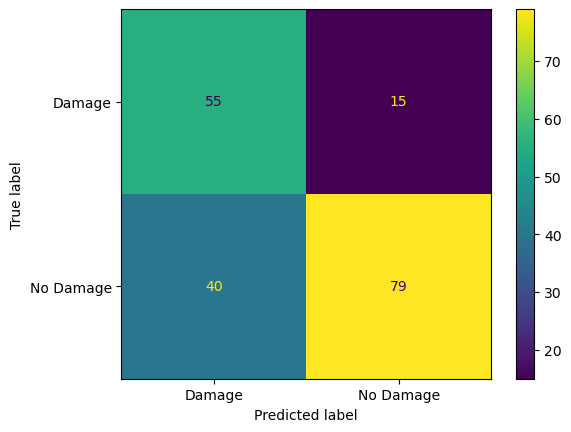

In [36]:
#Count Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(gt, preds, labels = ['Damage','No Damage'])
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix, display_labels=['Damage','No Damage'])
disp.plot()

#Predicted Correctly, Wrongly ------------- PREDICTED Wrong   or     PREDICTED Correct
total = len(preds)
d_pred = preds.count('Damage')
nd_pred = preds.count('No Damage')

d_gt = gt.count('Damage')
nd_gt = gt.count('No Damage')

correct = matrix[0][0]+matrix[1][1]
wrong = matrix[0][1]+matrix[1][0]

d_correct = matrix[0][0]
d_wrong = matrix[1][0]
nd_correct = matrix[1][1]
nd_wrong = matrix[0][1]

#Accuracy
accuracy = sklearn.metrics.accuracy_score(gt, preds)

#Recall (Sensitivity)
recall = sklearn.metrics.recall_score(gt, preds, average=None)

#Cohen's Kappa
cohen = sklearn.metrics.cohen_kappa_score(gt, preds)

#Matthews
matthews = sklearn.metrics.matthews_corrcoef(gt, preds)

#Precision
precision = sklearn.metrics.precision_score(gt, preds, average=None)

#F1 Score
f1 = sklearn.metrics.f1_score(gt, preds, average=None)

print(d_pred, nd_pred, d_gt, nd_gt)
print(correct, wrong)
print(d_correct, d_wrong, nd_correct, nd_wrong)
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall_d: {recall[0]:.4f}")
print(f"Recall_nd: {recall[1]:.4f}")
print(f"Cohen's Kappa_d: {cohen:.4f}")
print(f"Matthews Correlation Coefficient: {matthews:.4f}")
print(f"Precision_d: {precision[0]:.4f}")
print(f"Precision_nd: {precision[1]:.4f}")
print(f"F1 Score_d: {f1[0]:.4f}")
print(f"F1 Score_nd: {f1[1]:.4f}")

print(matrix)